In [4]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import os
import DataLoad
import ImagePreprocessor
import Labeling
import TrajectoryPhy
import umap
import ReadParam

In [5]:
report_path = 'result/report_all.csv'
header, data = DataLoad.read_report(report_path)
print(header)
print(data[0])

['filename', 'id', 'class_id', 'class_name', 'probability', 'maximum_radius', 'first_x_position', 'first_y_position']
{'filename': '20220301_H2B Halo_Field3_no_ir001', 'id': '2', 'class_id': '0', 'class_name': 'Immobile', 'probability': '0.9990927', 'maximum_radius': '0.08163692542593697', 'first_x_position': '12.683669', 'first_y_position': '12.079526'}


In [8]:
def ratio_calcul(data):
    total = len(data)
    immobile = 0
    hybrid = 0
    mobile = 0
    for histone in data:
        if histone['class_id'] == '0':
            immobile += 1
        if histone['class_id'] == '1':
            hybrid += 1
        if histone['class_id'] == '2':
            mobile += 1
    return immobile/total, hybrid/total, mobile/total

In [7]:
ratio_calcul(data)

(0.8084820967908368, 0.1333195748632752, 0.05819832834588794)

In [36]:
max_rs_immobile = np.array(list([float(x['maximum_radius']) for x in data if x['class_id']=='0']))
max_rs_hybrid = np.array(list([float(x['maximum_radius']) for x in data if x['class_id']=='1']))
max_rs_mobile = np.array(list([float(x['maximum_radius']) for x in data if x['class_id']=='2']))

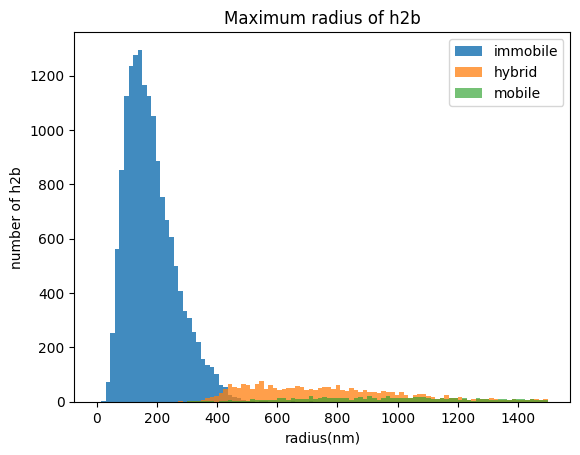

In [44]:
plt.figure()
plt.title('Maximum radius of h2b')
plt.hist(max_rs_immobile*1000, range = (0, 1500), bins = 100, alpha=0.85, label='immobile')
plt.hist(max_rs_hybrid*1000, range = (0, 1500), bins = 100, alpha=0.75, label='hybrid')
plt.hist(max_rs_mobile*1000, range = (0, 1500), bins = 100, alpha=0.65, label='mobile')
plt.xlabel('radius(nm)')
plt.ylabel('number of h2b')
plt.legend()
plt.show()

In [2]:
data_path = './data/TrainingSample'
print(f'Loading the data...')
histones = DataLoad.read_files(path=data_path, cutoff=10, chunk=False)
histones_label = Labeling.make_label(histones, radius=0.45, density=0.4)

print(f'Image processing...')
ImagePreprocessor.make_channel(histones, immobile_cutoff=0.3, hybrid_cutoff=10, nChannel=3)
histones_imgs, img_size, time_scale = \
    ImagePreprocessor.preprocessing(histones, img_scale=10, amp=2)

print(f'Making imgs...')
zoomed_imgs, scaled_size = ImagePreprocessor.zoom(histones_imgs, size=img_size, to_size=(500, 500))

reshaped_label = []
reshaped_imgs = []
for histone in zoomed_imgs:
    reshaped_imgs.append(zoomed_imgs[histone].reshape(-1))
    reshaped_label.append(histones_label[histone])
reshaped_imgs = np.array(reshaped_imgs)
print(reshaped_imgs.shape)

reducer = umap.UMAP(n_neighbors=5)
embedding = reducer.fit_transform(reshaped_imgs)
print(f'Data reducing end')

Loading the data...
Image processing...
Making imgs...
(2400, 750000)
Data reducing end


(2400, 2)


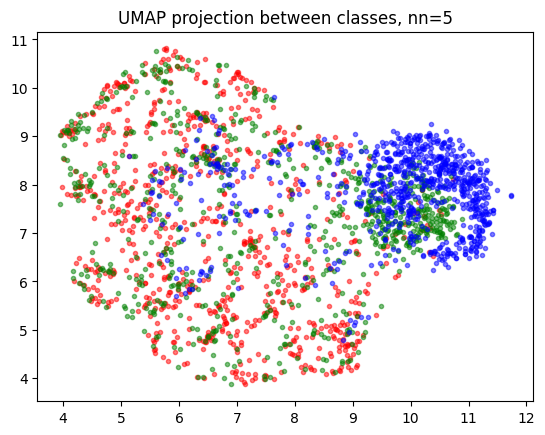

In [3]:
print(embedding.shape)  
color_vec = []
for i in range(len(reshaped_label)):
    if reshaped_label[i] == 0:
        color_vec.append('red')
    elif reshaped_label[i] == 1:
        color_vec.append('green')
    else:
        color_vec.append('blue')
        
fig, ax = plt.subplots()
for p in range(reshaped_imgs.shape[0]):
    ax.scatter(
        embedding[p][0],
        embedding[p][1],
        color=color_vec[p],
        alpha=0.5,
        s=9
    )
plt.title(f'UMAP projection between classes, nn=5', fontsize=12)
plt.savefig(f'img/training_imgs/1.png')

In [6]:
def cell_class_map(classified_histones, show):
    plt.figure()
    ax = plt.axes()
    ax.set_facecolor("black")
    for histone in classified_histones:
        f_x_pos = float(histone['first_x_position'])
        f_y_pos = float(histone['first_y_position'])
        max_r = float(histone['maximum_radius'])
        label = int(histone['class_id'])
        if label in show:
            if label == 0:
                c = 'red'
            if label == 1:
                c = 'green'
            if label == 2:
                c = 'blue'
            plt.scatter(f_x_pos, f_y_pos, c=c, s=max_r*100, alpha=0.35)

(0.8361581920903954, 0.07909604519774012, 0.0847457627118644)

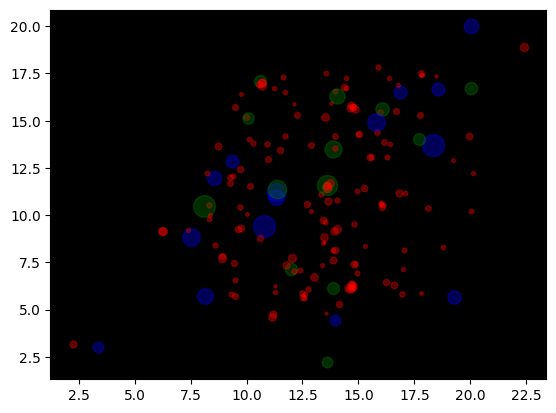

In [9]:
report_path = 'result/scratch1.csv'
header, data = DataLoad.read_report(report_path)
cell_class_map(data, [0,1,2])
ratio_calcul(data)

(0.7368421052631579, 0.07518796992481203, 0.18796992481203006)

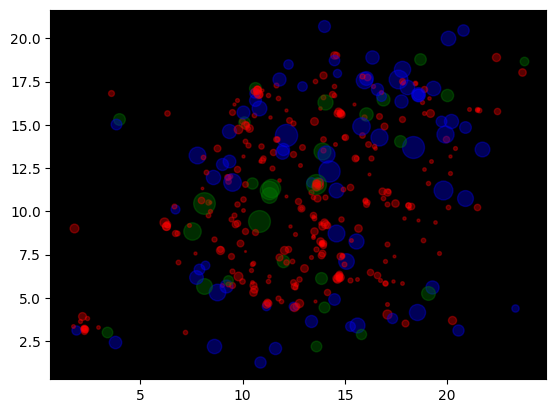

In [9]:
report_path = 'result/report.csv'
header, data = DataLoad.read_report(report_path)
cell_class_map(data, [0,1,2])
ratio_calcul(data)

(0.803921568627451, 0.10784313725490197, 0.08823529411764706)

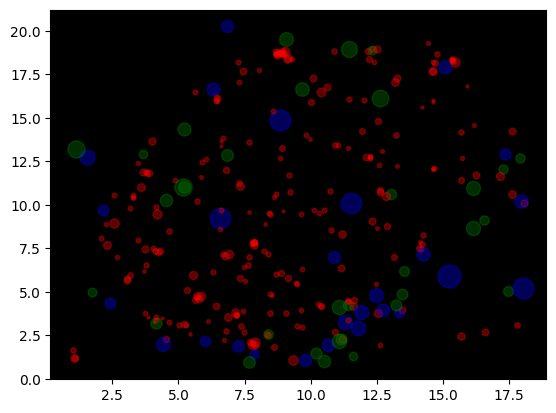

In [10]:
report_path = 'result/scratch3.csv'
header, data = DataLoad.read_report(report_path)
cell_class_map(data, [0,1,2])
ratio_calcul(data)

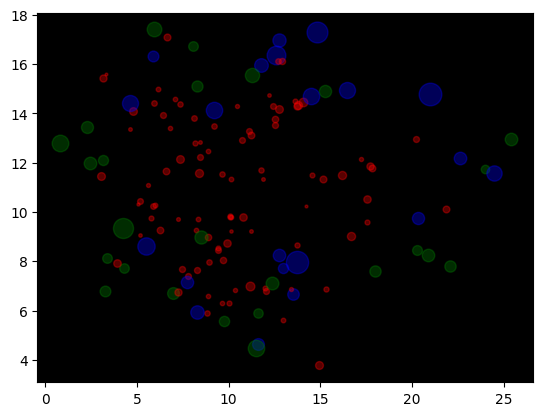

In [11]:
report_path = 'result/scratch4.csv'
header, data = DataLoad.read_report(report_path)
cell_class_map(data, [0,1,2])
ratio_calcul(data)

(0.7701863354037267, 0.13043478260869565, 0.09937888198757763)

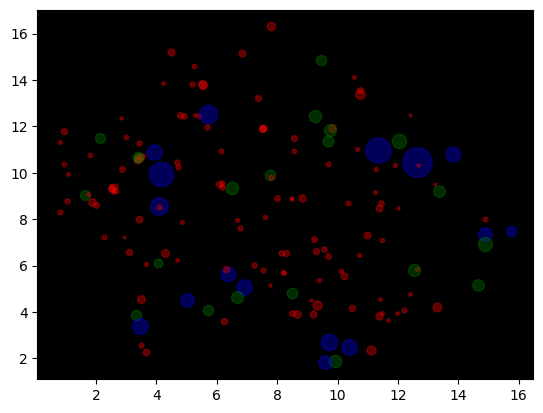

In [12]:
report_path = 'result/scratch5.csv'
header, data = DataLoad.read_report(report_path)
cell_class_map(data, [0,1,2])
ratio_calcul(data)

(0.8407079646017699, 0.07964601769911504, 0.07964601769911504)

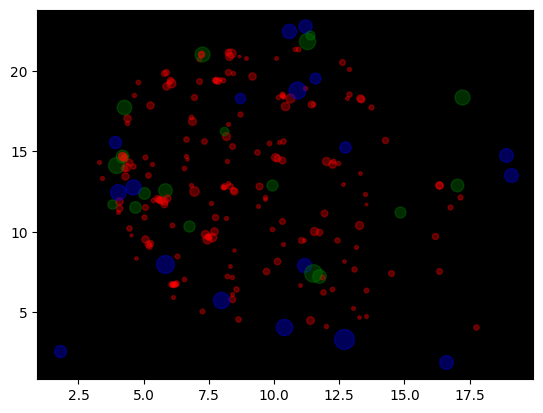

In [11]:
report_path = 'result/scratch6.csv'
header, data = DataLoad.read_report(report_path)
cell_class_map(data, [0,1,2])
ratio_calcul(data)

In [ ]:
print(f'Loading the data...')
data_path = 'data/1_WT-H2BHalo_noIR/whole cells/Concatenation_20220217_20220301_20220601_H2B_Halo_before_entire_Cell'
params = ReadParam.read('.')
nn = []
for co in range(1,20):
    histones = DataLoad.read_files(path=data_path, cutoff=co, group_size=params['group_size'])
    a = {}
    for hist in histones:
        a |= hist
    nn.append(len(a))
plt.figure()
plt.title('Number of h2b by cutoff')
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], nn)
plt.xlabel('cutoff')
plt.ylabel('number of h2b')
plt.legend()
plt.show()

Loading the data...
